# TS8: Filtrado No Lineal

En la TS7 se experimentaron t√©cnicas de filtrado lineal para la mitigaci√≥n de interferencias en la se√±al electrocardiogr√°fica (ECG). Tal vez la interferencia que m√°s exigi√≥ el dise√±o de los filtros digitales ha sido el movimiento de l√≠nea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocasiones de alta energ√≠a. En esta tarea semanal se analizar√°n t√©cnicas no lineales de estimaci√≥n/substracci√≥n de la se√±al de movimiento de base $b(n)$.

$$
\hat{x} = s - \hat{b}
$$

Siendo $s$ la se√±al de ECG registrada con interferencias, y $\hat{x}$ la se√±al filtrada, una estimaci√≥n del ECG sin interferencias.

Se pide que se implementen ambas estimaciones de $\hat{b}$ detalladas a continuaci√≥n:

---

## 1) Filtro de mediana

Se estima $\hat{b}$ a partir de la siguiente expresi√≥n:

$$
\hat{b} = \text{med}_{600} \left( \text{med}_{200}(s) \right)
$$

Siendo $\text{med}_t(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la se√±al $s$, es decir:

$$
\hat{b}[n] = \text{med}(m[n], m[n-1], \dots, m[n - 600 \cdot fs])
$$

donde:

$$
m[n] = \text{med}(s[n], s[n-1], \dots, s[n - 200 \cdot fs])
$$

**Ayuda**: Puede utilizar la implementaci√≥n del filtro de mediana provista en `scipy.signal`.

---

## 2) Interpolaci√≥n mediante splines c√∫bicos

A partir de las detecciones provistas en `ecg.mat` (campo `qrs_detections`), puede estimar el nivel isoel√©ctrico, es decir, el momento donde la actividad el√©ctrica card√≠aca es aproximadamente nula. El intervalo entre la onda P y Q es el momento m√°s adecuado para estimar las caracter√≠sticas de la interferencia que originan el movimiento de la l√≠nea de base. En ese momento, el impulso card√≠aco es demorado al atravesar el n√≥dulo aur√≠culo-ventricular.

Para la localizaci√≥n del segmento PQ puede valerse de la localizaci√≥n de cada latido (l√≠neas rojas verticales $n_i$) y, a partir de la misma, anticipar un tiempo adecuado $n_0$ de manera tal de no incluir la onda P ni Q. Esto resultar√° en un conjunto de valores:

$$
S = \{ (m_i, s(m_i)) \mid i = 1, 2, \dots, Q \}
$$

donde $m_i = n_i - n_0$ y $Q$ es la cantidad de latidos en el registro (1903).

Recuerde que la se√±al de l√≠nea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que deber√≠a remuestrear dicha se√±al (puede usar la funci√≥n de interpolaci√≥n spline para ello):

$$
\hat{b}(n) = \text{spline3}(S, n), \quad n = 1, 2, \dots, N
$$

donde la funci√≥n `spline3` ser√° la responsable de realizar la interpolaci√≥n para las $N$ muestras de la se√±al $s$.

---

## 3) Filtro adaptado (matched filter)

Aplique el concepto de filtro adaptado para dise√±ar un detector de latidos. Utilice el patr√≥n provisto en el campo `qrs_pattern1`.

**Ayuda**: Revise el concepto de filtro adaptado en Wikipedia o en la bibliograf√≠a de la materia (Porat, secci√≥n 14.4.9).

### a) Explicar conceptualmente

Explique conceptualmente c√≥mo podr√≠a realizar un detector de latidos con la se√±al resultante del filtro adaptado. Discuta la utilidad y limitaciones de este m√©todo.

### b) Implementar la detecci√≥n

Realice la detecci√≥n de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable `qrs_detections`. Proponga alguna m√©trica (por ejemplo: **sensibilidad**, **valor predictivo positivo**) para cuantificar la performance del detector.


In [100]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from pytc2.sistemas_lineales import plot_plantilla
from scipy import signal as sig
import scipy.io as sio

In [101]:
from utils_info import print_info_senal
fs = 1000  # Hz
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_lead = mat_struct['ecg_lead'].flatten()
ecg_lead = (ecg_lead - ecg_lead.mean())/ ecg_lead.std() 
N = ecg_lead.shape[0]
print_info_senal('ECG', ecg_lead, fs)

------ECG------
Cantidad de muestras:  1129116
Frecuencia de muestreo: 1000 Hz
Duracion de la se√±al: 1129.116 seg
Df: 0.001 Hz
Potencia:  1.0



## Filtrado NO lineal.
- Sirve principalmente para remover ruido correlado. Es decir, cuando el ruido esta metido en la banda util, y a trravez de un FIR no lo podemos eliminar

Ambas tecncias de filtrados constan de lo mismo, estimar los movimientos de linea de base para despues restarlos

### Filtrado de mediana

El filtrado de mediana es una operaci√≥n **no lineal** que se utiliza para estimar el nivel fisiol√©ctrico de base de la se√±al ECG, sin verse afectado por los complejos QRS.

La mediana es b√°sicamente un **percentil 50**, es decir, toma el valor central de una ventana deslizante de tama√±o $M$. A diferencia de un promedio, no se ve afectada por valores extremos, lo cual la hace √∫til para separar componentes lentas de la se√±al.

La **clave de este filtrado** es que el tama√±o de la ventana debe ser **mayor al ancho del complejo QRS**, as√≠ no lo incluye en el c√°lculo y queda preservado. Por eso:

- Primero se aplica un filtro con ventana de **200 ms** para suavizar la se√±al.  
- Luego, otra pasada con una ventana de **600 ms**, que captura mejor la l√≠nea de base lenta.  
- Finalmente, se estima la se√±al libre de la l√≠nea base restando:  
  `ecg_lead_est_med = ecg_lead - ecg_lead_med2`


In [102]:
from scipy.signal import medfilt

''' 1¬∞: Filtrado de mediana con ventana de 200 milisegundos '''
M1 = int(0.2 * fs)  
ecg_lead_med1 = medfilt(ecg_lead, kernel_size=M1 | 1) # correccion :) 

''' 2¬∞: Filtrado de mediana con ventana de 600 milisegundos '''
M2 = int(0.6 * fs)
ecg_lead_med2 = medfilt(ecg_lead_med1, kernel_size=M2 | 1)
ecg_lead_est_med = ecg_lead - ecg_lead_med2

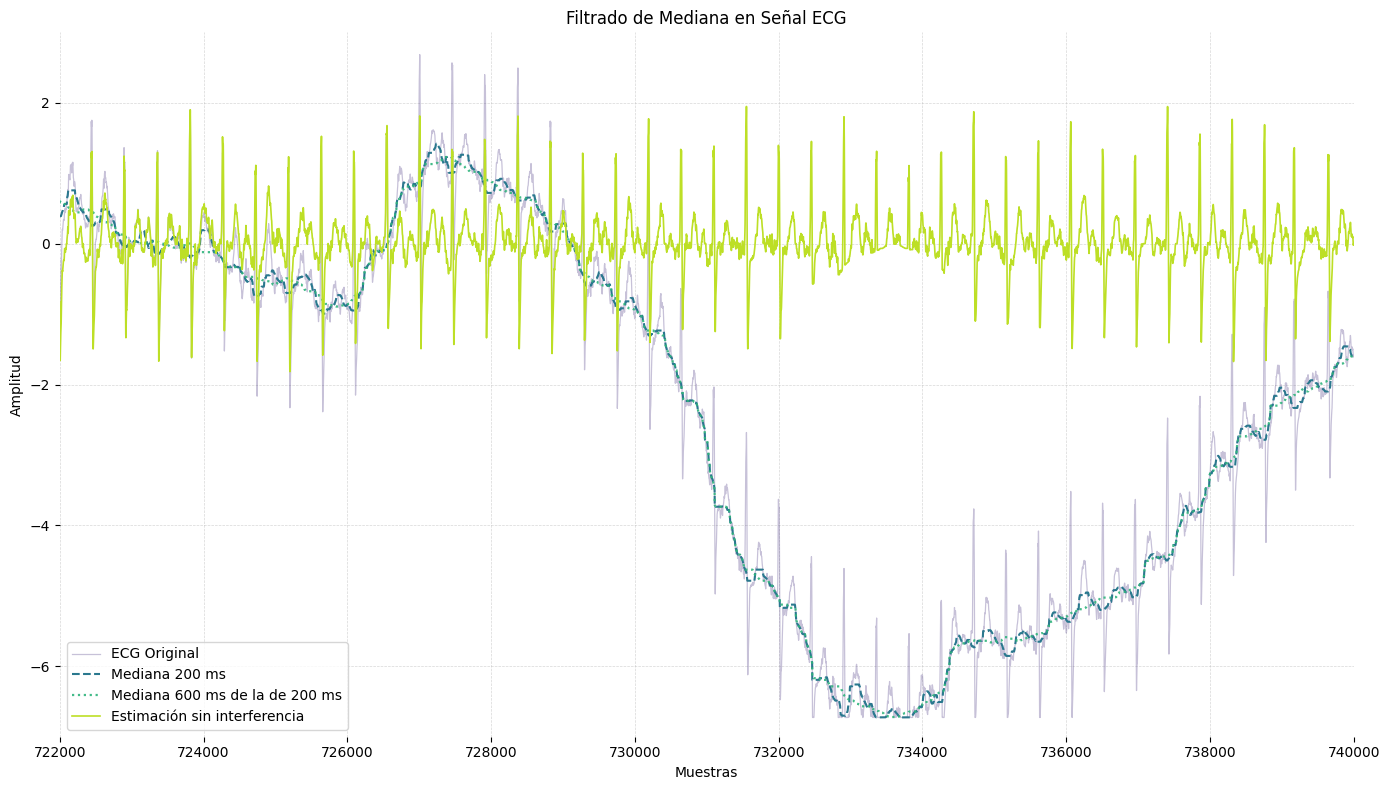

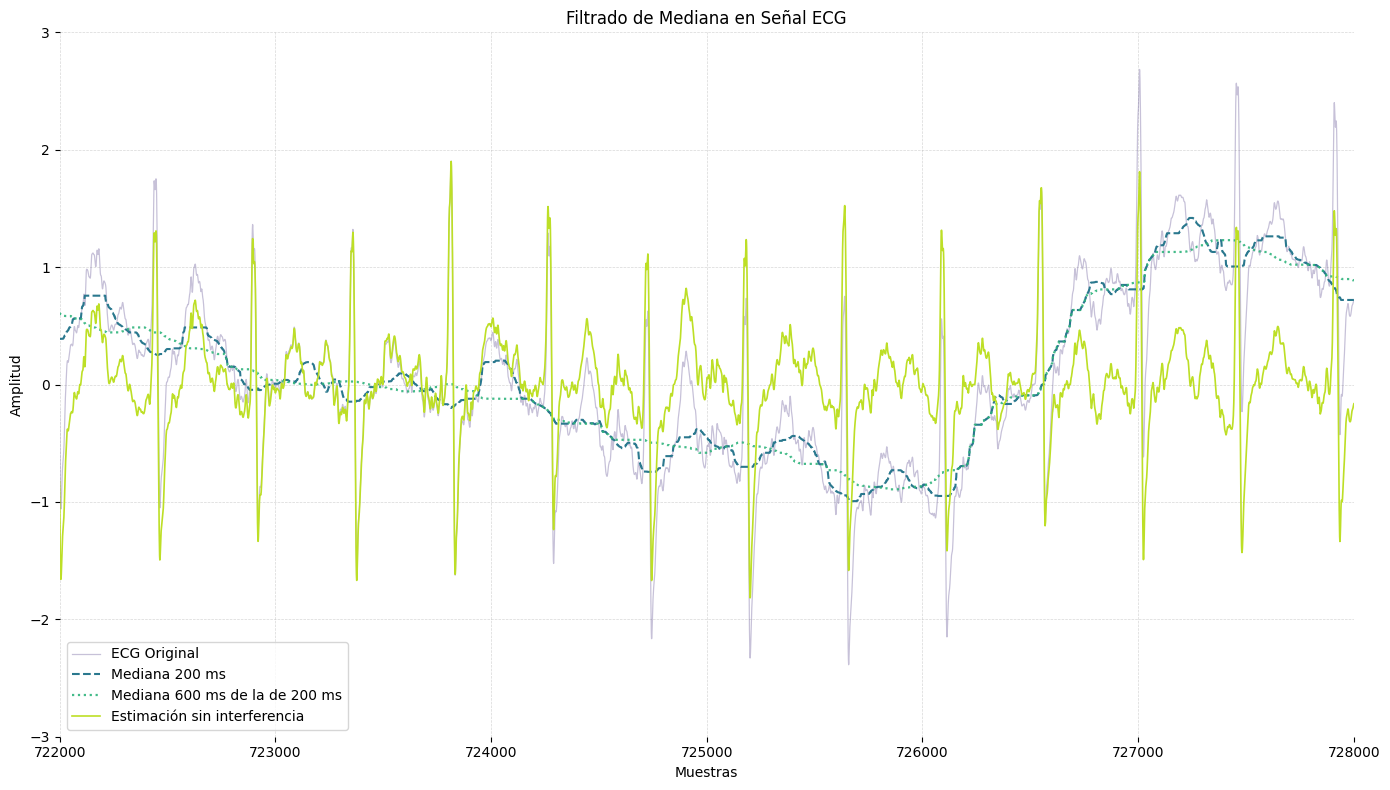

In [103]:
import matplotlib.pyplot as plt
from matplotlib import colormaps


plt.style.use("seaborn-v0_8-muted")


cmap = colormaps['viridis']
col1 = cmap(0.15)
col2 = cmap(0.4)
col3 = cmap(0.65)
col4 = cmap(0.9)

plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(ecg_lead_med1, label='Mediana 200 ms', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_med2, label='Mediana 600 ms de la de 200 ms', lw=1.6, ls=':', c=col3, alpha=0.9)
plt.plot(ecg_lead_est_med, label='Estimaci√≥n sin interferencia', lw=1.2, c=col4)

plt.xlim(722000, 740000)
plt.ylim(-7, 3)
plt.title('Filtrado de Mediana en Se√±al ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.02)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(ecg_lead_med1, label='Mediana 200 ms', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_med2, label='Mediana 600 ms de la de 200 ms', lw=1.6, ls=':', c=col3, alpha=0.9)
plt.plot(ecg_lead_est_med, label='Estimaci√≥n sin interferencia', lw=1.2, c=col4)

plt.xlim(722000, 728000)
plt.ylim(-3, 3)
plt.title('Filtrado de Mediana en Se√±al ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.02)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

### Metodo de Cubic Splines

### Estimaci√≥n de la l√≠nea de base con interpolaci√≥n spline

Se usaron las detecciones de QRS (`qrs_detections`) para estimar el nivel isoel√©ctrico.  
A cada latido $n_i$ se le restaron 85 ms para obtener el punto $m_i$ dentro del segmento PQ:

$$
m_i = n_i - n_0 \quad \text{con} \quad n_0 = 0.085 \cdot f_s
$$

Con esos puntos se arm√≥ el conjunto:

$$
S = \{(m_i, s(m_i))\}
$$

Despu√©s se aplic√≥ interpolaci√≥n spline c√∫bica para estimar la l√≠nea de base $\hat{b}(n)$ en toda la se√±al:

$$
\hat{b}(n) = \text{spline3}(S, n)
$$

Y se obtuvo la se√±al corregida:

$$
\hat{s}(n) = s(n) - \hat{b}(n)
$$

Se eligi√≥ $n_0 = 85$ ms como desplazamiento hacia atr√°s desde cada latido porque ese valor cae dentro del segmento PQ,  es decir, **despu√©s de la onda P pero antes del inicio del complejo QRS**.  Esto asegura que el punto $m_i = n_i - n_0$ est√© en una zona donde la actividad el√©ctrica card√≠aca es m√≠nima,  lo cual es ideal para estimar la l√≠nea de base.

El valor fue elegido considerando que el segmento PQ suele durar entre 80 y 120 ms,  y que el complejo QRS comienza inmediatamente despu√©s. Elegir 85 ms permite evitar incluir la onda P.


In [104]:
qrs_detections = mat_struct['qrs_detections'].flatten()

n0 = int(0.085 * fs)  # 85 ms
indice_seg_isoelectrico = qrs_detections - n0
indice_seg_isoelectrico = indice_seg_isoelectrico[indice_seg_isoelectrico > 0]
indice_seg_isoelectrico = indice_seg_isoelectrico[indice_seg_isoelectrico < N]
seg_isoelectrico = ecg_lead[indice_seg_isoelectrico]


from scipy.interpolate import CubicSpline

spline_func = CubicSpline(indice_seg_isoelectrico, seg_isoelectrico)
b_hat_spline = spline_func(np.arange(N))

ecg_lead_est_spline = ecg_lead - b_hat_spline

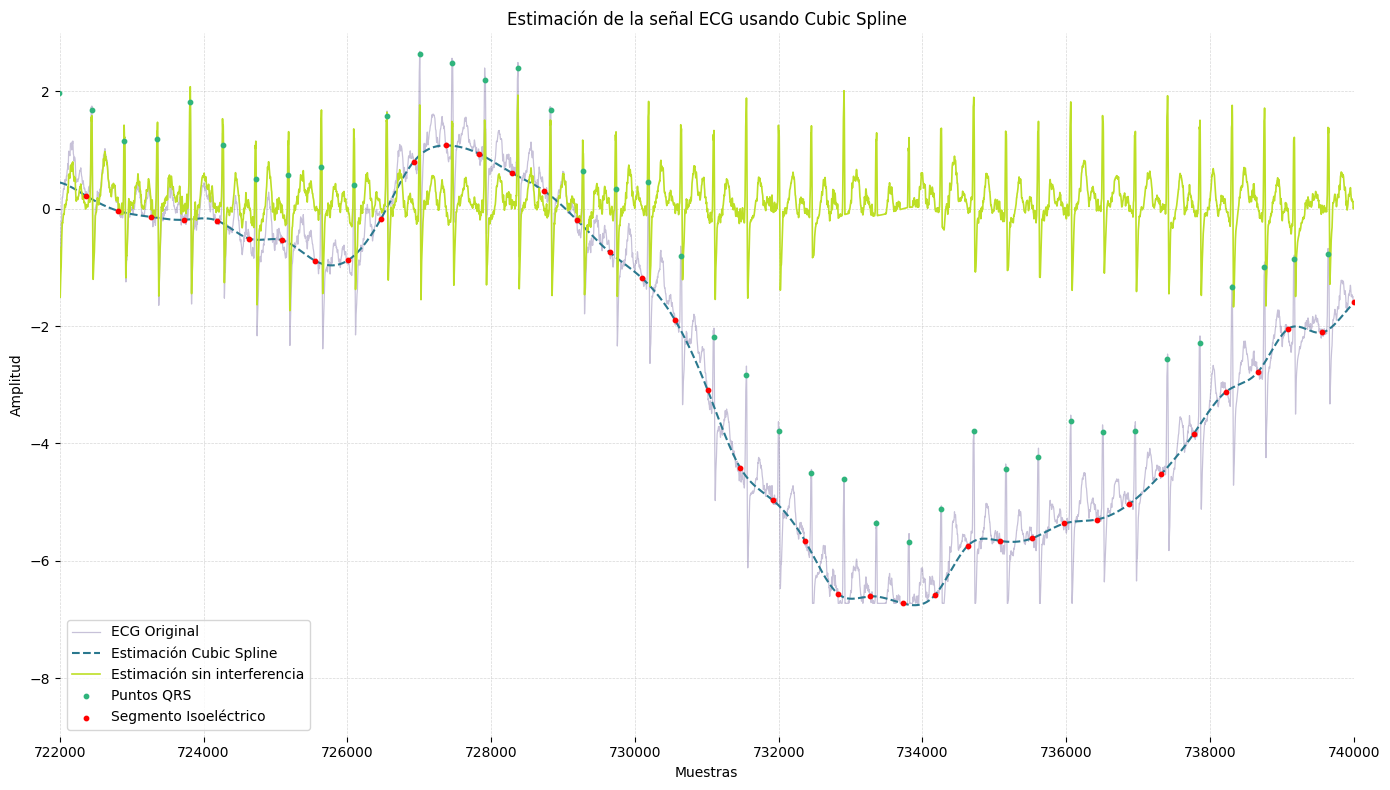

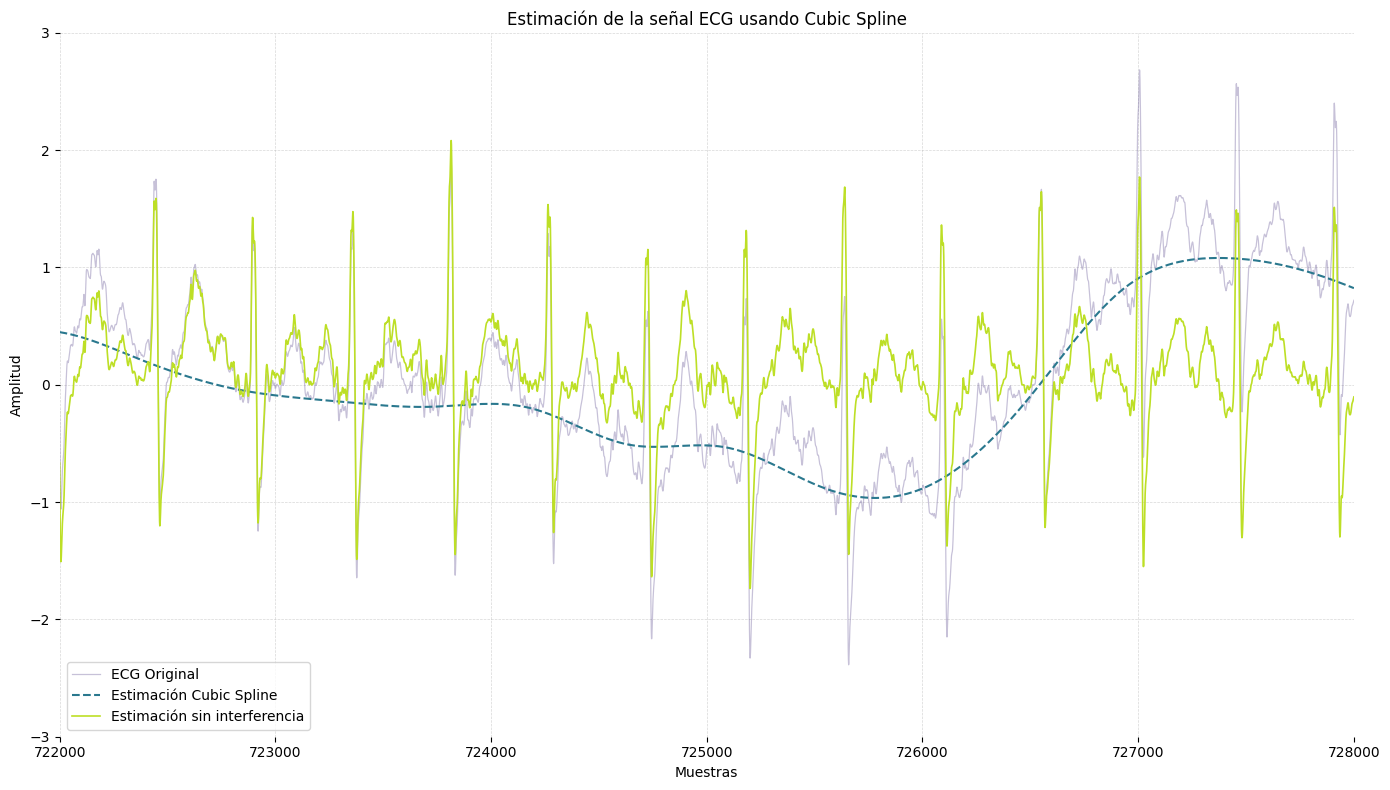

In [105]:
plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(b_hat_spline, label='Estimaci√≥n Cubic Spline', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_est_spline, label='Estimaci√≥n sin interferencia', lw=1.2, c=col4)
plt.scatter(qrs_detections, ecg_lead[qrs_detections], color=col3, label='Puntos QRS', s=10, zorder=5)
plt.scatter(indice_seg_isoelectrico, seg_isoelectrico, color='red', label='Segmento Isoel√©ctrico', s=10, zorder=5)
plt.xlim(722000, 740000)
plt.ylim(-9, 3)
plt.title('Estimaci√≥n de la se√±al ECG usando Cubic Spline')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(b_hat_spline, label='Estimaci√≥n Cubic Spline', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_est_spline, label='Estimaci√≥n sin interferencia', lw=1.2, c=col4)
#plt.scatter(qrs_detections, ecg_lead[qrs_detections], color=col3, label='Puntos QRS', s=10, zorder=5)
#plt.scatter(indice_seg_isoelectrico, seg_isoelectrico, color='red', label='Segmento Isoel√©ctrico', s=10, zorder=5)
plt.xlim(722000, 728000)
plt.ylim(-3, 3)
plt.title('Estimaci√≥n de la se√±al ECG usando Cubic Spline')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

### Matched Filter: Para detectar complejos qrs



Para detectar los latidos, apliqu√© el concepto de **filtro adaptado (matched filter)**. Este tipo de filtro se utiliza cuando se quiere detectar una se√±al conocida dentro de una se√±al m√°s larga y ruidosa. En este caso, la se√±al conocida es un **patr√≥n de complejo QRS t√≠pico**, provisto en el archivo `ecg.mat` bajo el nombre `qrs_pattern1`.

La idea es **correlacionar** ese patr√≥n con la se√±al de ECG corregida (`ecg_lead_est_spline`), y de esa forma obtener una se√±al de salida (`ecg_corr`) donde los picos marcan los lugares donde la forma del QRS aparece con mayor similitud. La correlaci√≥n act√∫a como un detector que responde fuerte cuando la se√±al actual se parece al patr√≥n.

Para realizar la detecci√≥n de los latidos:
- Normalic√© el patr√≥n QRS para que tenga media cero y desviaci√≥n est√°ndar uno.
- Correlacion√© ese patr√≥n con la se√±al de ECG.
- Luego normalic√© la se√±al de correlaci√≥n.
- Finalmente, utilic√© `find_peaks` para identificar los m√°ximos locales por encima de un umbral (10% del valor m√°ximo), y separarlos al menos 100 ms entre s√≠.


#### limitaciones con las que me cruce:

- Puede generar **falsos positivos** si otras partes de la se√±al tienen una forma similar al QRS. (Spoiler: Pasa)


In [106]:
''' Cargo complejo QRS'''
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
qrs_pattern = (qrs_pattern - qrs_pattern.mean()) / qrs_pattern.std()

''' Correlaciono '''
from scipy.signal import correlate
ecg_corr = correlate(ecg_lead_est_spline, qrs_pattern, mode='same')
ecg_corr = ecg_corr - np.mean(ecg_corr) 
ecg_corr = ecg_corr / np.std(ecg_corr)

'''Deteci√≥n de picos'''
from scipy.signal import find_peaks
peaks, _ = find_peaks(ecg_corr, height=np.max(ecg_corr) * 0.1, distance=int(fs * 0.1))


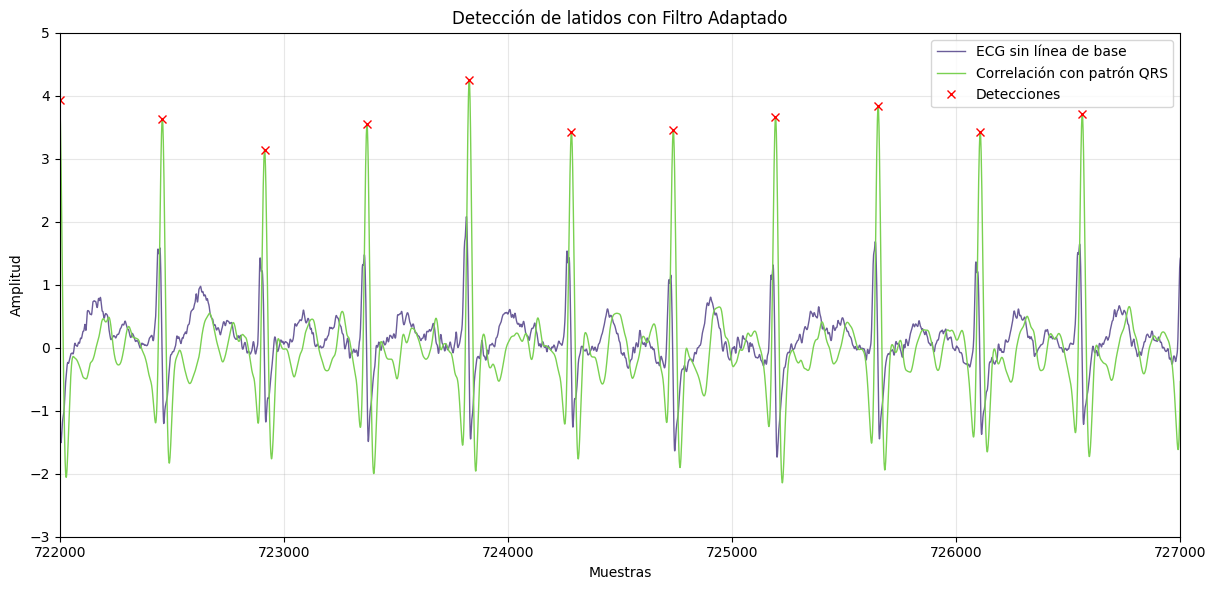

In [107]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

plt.style.use("seaborn-v0_8-muted")
cmap = colormaps['viridis']
col1 = cmap(0.15)  # ECG sin l√≠nea base
col2 = cmap(0.8)   # correlaci√≥n

plt.figure(figsize=(12, 6))
plt.plot(ecg_lead_est_spline, label='ECG sin l√≠nea de base', lw=1.0, c=col1, alpha=0.8)
plt.plot(ecg_corr, label='Correlaci√≥n con patr√≥n QRS', lw=1.0, c=col2)
plt.plot(peaks, ecg_corr[peaks], 'rx', label='Detecciones')

plt.title("Detecci√≥n de latidos con Filtro Adaptado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlim(722000, 727000)
plt.ylim(-3, 5)
plt.show()



#### Evaluaci√≥n de la detecci√≥n de picos

A partir de los puntos reales (`qrs_detections`), defino intervalos de ¬±50 ms.  
La idea es ver si los picos detectados por el filtro adaptado caen dentro de esos intervalos.  
Si cae, es un acierto. Si no, falso positivo.  
Tambi√©n se puede ver cu√°ntos reales no fueron detectados (falsos negativos).

Con eso armo la matriz de confusi√≥n y saco m√©tricas.


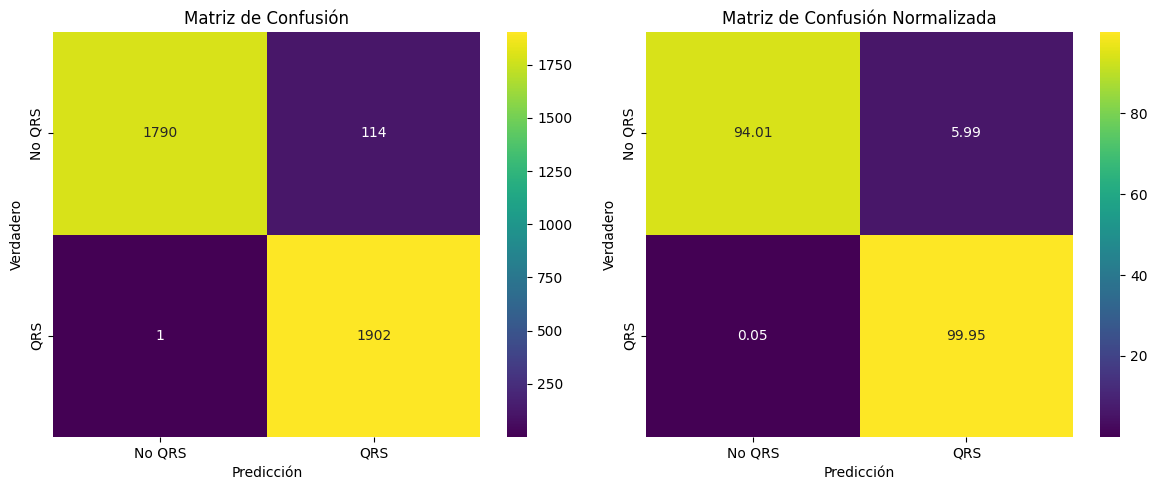

In [108]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tolerancia_muestras = int(0.05 * fs)

'''intervalos de eventos (+- 50ms alrededor de cada QRS)'''
eventos = []
for qrs in qrs_detections:
    ini = max(0, qrs - tolerancia_muestras)
    fin = min(len(ecg_lead_est_spline), qrs + tolerancia_muestras + 1)
    eventos.append((ini, fin))

'''intervalos de NO EVENTO: todo lo que no este en eventos'''
no_eventos = []
inicio = 0
for (ini, fin) in eventos:
    if inicio < ini:
        no_eventos.append((inicio, ini))
    inicio = fin
if inicio < len(ecg_lead_est_spline):
    no_eventos.append((inicio, len(ecg_lead_est_spline)))

'''Evaluaci√≥n de la detecci√≥n de picos'''
TP = 0
FN = 0
for ini, fin in eventos:
    if np.any((peaks >= ini) & (peaks < fin)):
        TP += 1
    else:
        FN += 1

''' Evaluaci√≥n de los no eventos '''
TN = 0
FP = 0
for ini, fin in no_eventos:
    if np.any((peaks >= ini) & (peaks < fin)):
        FP += 1
    else:
        TN += 1


y_true = [1]*TP + [1]*FN + [0]*FP + [0]*TN
y_pred = [1]*TP + [0]*FN + [1]*FP + [0]*TN

cm = confusion_matrix(y_true, y_pred)


labels = ["No QRS", "QRS"]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicci√≥n")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusi√≥n")

plt.subplot(1,2,2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels)
sns.heatmap(100 * cm / cm.sum(axis=1, keepdims=True), annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicci√≥n")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusi√≥n Normalizada")
plt.tight_layout()
plt.show()

Hice lo siguiente:

Considero evento Real al intervalo (qrs_detections - 50ms ; qrs_detections + 50ms) , todo el resto de la se√±al lo considero NO evento. 
como se ve en la matriz de confusion el 100% (en realidad es es 100% redondeado, de los 1903 complejos, 1902 fueron detectados) de los complejos qrs fueron detectados. Sin embargo del 100% de los fragmentos de la se√±al que NO 
son qrs, un 6% (114 segmentos) fue erroneamente identificado como qrs cuando no lo es. 

### Mas M√©tricas de Evaluaci√≥n

Ademas, se utilizaron las siguientes m√©tricas para evaluar la calidad de la detecci√≥n de eventos (latidos).

- **Accuracy (Exactitud):**  
  Mide la proporci√≥n total de decisiones correctas (verdaderos positivos y verdaderos negativos) sobre el total de evaluaciones realizadas.  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision (Valor Predictivo Positivo):**  
  Mide qu√© proporci√≥n de las detecciones positivas fueron realmente verdaderas. 
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensibilidad):**  
  Mide qu√© proporci√≥n de los eventos reales fueron correctamente detectados. 
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

  


In [109]:

accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.2f}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
print(f"Precision: {precision:.2f}")

recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"Recall: {recall:.2f}")



Accuracy: 0.97
Precision: 0.94
Recall: 1.00


### Conclusiones Finales
Los filtros no lineales resultaron muy √∫tiles para remover interferencias de baja frecuencia dentro de la banda de inter√©s, algo que los filtros lineales no pod√≠an resolver bien.
Tanto el m√©todo de splines c√∫bicos como el de filtrado de mediana funcionaron bien para estimar la l√≠nea de base. Sin embargo, el m√©todo de splines requiere conocer las posiciones de los QRS para poder ubicar el segmento PQ, mientras que el filtro de mediana es mucho m√°s sencillo y no necesita tanta informaci√≥n previa.

Por otro lado, el matched filter funcion√≥ bastante bien: detect√≥ casi todos los latidos (fall√≥ solo uno), aunque tuvo el problema de falsos positivos. Eso muestra que si bien es sensible, no es del todo espec√≠fico.

### Bonus 

üíé ¬øPodr√≠a funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?

No creo. El filtro adaptado calcula la correlaci√≥n entre un latido ‚Äúmodelo‚Äù y la se√±al. Si ese modelo es de otra persona, lo m√°s probable es que la forma del latido no coincida bien, as√≠ que la correlaci√≥n va a ser baja y el detector no va a funcionar bien.
Capaz para algo m√°s general, donde haya m√°s variabilidad entre latidos, conviene usar otro tipo de detector, como uno basado en transformadas de onditas, que son m√°s robustas a cambios en la forma.

üíé Proponga alguna mejora a los estimadores de la se√±al  b, como por ejemplo usar las t√©cnicas multirate. 
Una opci√≥n es usar t√©cnicas multirate. Por ejemplo, pod√©s diezmar la se√±al, estimar la l√≠nea de base $b$ sobre esa versi√≥n diezmada (donde los QRS est√°n m√°s "aplastados") y despu√©s interpolar la estimaci√≥n para volver al tama√±o original. Al reducir la cantidad de muestras, el c√°lculo es m√°s eficiente y se evita que el QRS "ensucie" tanto la estimaci√≥n.
Despu√©s pod√©s usar interpolaci√≥n tipo CubicSpline para volver a la frecuencia original y rest√°rselo al ECG original.